# FBI crime report analysis
##### The objective of this notebook is to use **Machine Learning** models to predict crime data. I chose to predict the age (numerical) and race (categorical) of the offenders based on data from the victims (age, race, ethnicity, sex, etc), the relationship between victim and offender, crime location, crime type, etc. I'll be using North Dakota 2021 data.
##### This is an updated version taking into account some of **@thedevastator** feedback in the comments. For now I added LightGBM and also used the GPU for XGBoost. The rest of the suggestions are still pending.

![S](https://www.fbi.gov/image-repository/nibrs-logo-1.jpg/@@images/image/large)


   ![](https://media0.giphy.com/media/rCqHtYuB0a9re731gG/giphy.gif)

#### Library Imports

In [125]:
import itertools
import numpy as np
import pandas as pd
import os
import glob
import re
from tqdm import tqdm
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# modeling
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor,RandomForestRegressor,\
ExtraTreesRegressor,BaggingRegressor,RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,\
     AdaBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBRegressor,XGBClassifier
# data evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
     mean_squared_error,r2_score,mean_absolute_error,accuracy_score,balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
import warnings
from lightgbm import LGBMRegressor,LGBMClassifier
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None 
np.random.seed(31415)

#### Data Loading

In [126]:
state = 'ND-'
year = '2021'

file_path = rf'/kaggle/input/us-fbi-nibrs-crime-data-2021-all-states/{state}{year}/'
# list all the files from the directory
file_list = os.listdir(file_path)
csv_list = []
# list only csv files
for file in file_list:
    if re.search('.+csv', file):
        csv_list.append(file)
# dictionary of dataframes corresponding to each csv file, where the key is the
# dataframe name and the value is the actual data frame
df_dict = {file[:-4].lower(): pd.read_csv(rf'/kaggle/input/us-fbi-nibrs-crime-data-2021-all-states/{state}{year}/{file}')
           for file in csv_list}
# Since we chose the state and year, data_year and state columns don't give any extra information
# so we drop them
for key, val in df_dict.items():
    val=val[val.columns.drop(list(val.filter(regex='data_year')))].copy()
    val=val[val.columns.drop(list(val.filter(regex='state')))].copy()
    df_dict[key]=val
# Now we create variables for all the dictionary keys and assign to them
# the value from the respective value of the dictionary according to their key
locals().update(df_dict)

##### Merging the dataframes
###### For this project I chose to use the offenders data and ignore the arrestees since the former has more data, although caution should be taken that data collected for offenders that where not arrested might be less reliable

In [127]:
df_combined = pd.merge(nibrs_victim_offense, nibrs_offense,
                       how='outer', on='offense_id')
df_combined = pd.merge(df_combined, nibrs_suspect_using,
                       how='outer', on='offense_id')
df_combined = pd.merge(df_combined, nibrs_bias_motivation,
                       how='outer', on='offense_id')
nibrs_offender = pd.merge(nibrs_offender, nibrs_age,
                       how='outer',
                          on='age_id')
nibrs_offender = pd.merge(nibrs_offender, ref_race,
                          on='race_id')
nibrs_offender = pd.merge(nibrs_offender, nibrs_ethnicity,
                          on='ethnicity_id')
nibrs_victim = pd.merge(nibrs_victim, nibrs_age,
                       how='outer',
                        on='age_id')
nibrs_victim = pd.merge(nibrs_victim, ref_race, on='race_id')
nibrs_victim = pd.merge(nibrs_victim, nibrs_ethnicity,
                        on='ethnicity_id')
df_victim_offender = pd.merge(nibrs_victim, nibrs_offender,
                              on='incident_id', how='outer', suffixes=('_victim', '_offender'))
df_combined = pd.merge(df_combined, df_victim_offender,
                       how='outer', left_on=['incident_id', 'victim_id'], right_on=['incident_id',
                                                                                    'victim_id'])
df_combined = pd.merge(df_combined, nibrs_incident,
                       how='outer', on='incident_id')
df_combined = pd.merge(df_combined, nibrs_property,
                       how='outer', on='incident_id')
df_combined = pd.merge(df_combined, nibrs_property_desc,
                       how='outer', on='property_id')
df_combined = pd.merge(df_combined, nibrs_victim_offender_rel, how='outer', left_on=[
    'victim_id', 'offender_id'], right_on=[
        'victim_id', 'offender_id'])
df_combined = pd.merge(df_combined, nibrs_criminal_act,
                       how='outer', on='offense_id')
df_combined = pd.merge(df_combined, nibrs_weapon,
                       how='outer', on='offense_id')
df_combined = pd.merge(df_combined, nibrs_victim_injury,
                       how='outer', on='victim_id')
df_combined = pd.merge(df_combined, agencies,
                       how='outer', on='agency_id')
df_combined = pd.merge(df_combined, nibrs_offense_type, how='outer',
                       on='offense_code')
df_combined = pd.merge(df_combined, nibrs_prop_desc_type,
                       how='outer', on='prop_desc_id')
df_combined = pd.merge(df_combined, nibrs_location_type,
                       how='outer', on='location_id')
df_combined = pd.merge(df_combined, nibrs_bias_list,
                       how='outer', on='bias_id')
df_combined = pd.merge(df_combined, nibrs_weapon_type,
                       how='outer', on='weapon_id')
df_combined = pd.merge(df_combined, nibrs_relationship,
                       how='outer', on='relationship_id')
df_combined = pd.merge(df_combined, nibrs_victim_circumstances,
                       how='outer', on='victim_id')
df_combined = pd.merge(df_combined, nibrs_circumstances,
                       how='outer', on='circumstances_id')
df_combined = pd.merge(df_combined, nibrs_criminal_act_type,
                       how='outer', on='criminal_act_id')
df_combined = pd.merge(df_combined, nibrs_activity_type,
                       how='outer', on='activity_type_id')
df_combined = pd.merge(df_combined, nibrs_victim_type,
                       how='outer', on='victim_type_id')
df_combined = pd.merge(df_combined, nibrs_prop_loss_type,
                       how='outer', on='prop_loss_id')
df_combined = pd.merge(df_combined, nibrs_injury,
                       how='outer', on='injury_id')
df_combined = pd.merge(df_combined, nibrs_using_list, on='suspect_using_id')

#### Data preprocessing, cleaning and feature engineering
<a id='Data preprocessing, cleaning and feature engineering'></a>

In [128]:
# we create a copy of the combined dataframe to work on
df_cleaned=df_combined.copy()

In [129]:
# Let's see the complete dataframe
pd.set_option('display.max_columns', None)
df_cleaned

,victim_id,offense_id,incident_id,offense_code,attempt_complete_flag,location_id,num_premises_entered,method_entry_code,suspect_using_id,bias_id,victim_seq_num,victim_type_id,assignment_type_id,activity_type_id,outside_agency_id,age_id_victim,age_num_victim,sex_code_victim,race_id_victim,ethnicity_id_victim,resident_status_code,age_range_low_num_victim,age_code_range_high,age_code_victim,age_name_victim,race_code_victim,race_desc_victim,sort_order_victim,start_year_victim,end_year_victim,notes_victim,ethnicity_code_victim,ethnicity_name_victim,offender_id,offender_seq_num,age_id_offender,age_num_offender,sex_code_offender,race_id_offender,ethnicity_id_offender,age_range_low_num_offender,age_range_high_num,age_code_offender,age_name_offender,race_code_offender,race_desc_offender,sort_order_offender,start_year_offender,end_year_offender,notes_offender,ethnicity_code_offender,ethnicity_name_offender,agency_id,nibrs_month_id,cargo_theft_flag,submission_date,incident_date,report_date_flag,incident_hour,cleared_except_id,cleared_except_date,incident_status,data_home,orig_format,did,property_id,prop_loss_id,stolen_count,recovered_count,prop_desc_id,property_value,date_recovered,nibrs_prop_desc_id,relationship_id,nibrs_victim_offender_id,criminal_act_id,weapon_id,nibrs_weapon_id,injury_id,yearly_agency_id,ori,legacy_ori,covered_by_legacy_ori,direct_contributor_flag,dormant_flag,dormant_year,reporting_type,ucr_agency_name,ncic_agency_name,pub_agency_name,pub_agency_unit,agency_status,division_code,division_name,region_code,region_name,region_desc,agency_type_name,population,submitting_agency_id,sai,submitting_agency_name,suburban_area_flag,population_group_id,population_group_code,population_group_desc,parent_pop_group_code,parent_pop_group_desc,mip_flag,pop_sort_order,summary_rape_def,pe_reported_flag,male_officer,male_civilian,male_officer+male_civilian,female_officer,female_civilian,female_officer+female_civilian,officer_rate,employee_rate,nibrs_cert_date,nibrs_start_date,nibrs_leoka_start_date,nibrs_ct_start_date,nibrs_multi_bias_start_date,nibrs_off_eth_start_date,covered_flag,county_name,msa_name,publishable_flag,participated,nibrs_participated,offense_name,crime_against,ct_flag,hc_flag,hc_code,offense_category_name,offense_group,prop_desc_name,prop_desc_code,location_code,location_name,bias_code,bias_category,bias_desc,weapon_code,weapon_name,shr_flag,relationship_code,relationship_name,circumstances_id,justifiable_force_id,circumstance_type,circumstance_code,circumstance_name,criminal_act_code,criminal_act_name,criminal_act_desc,activity_type_code,activity_type_name,victim_type_code,victim_type_name,prop_loss_name,prop_loss_desc,injury_code,injury_name,suspect_using_code,suspect_using_name
0,147277785.0,161424052.0,134025398.0,290,C,25.0,NaN,NaN,4.0,88.0,1.0,3.0,NaN,NaN,NaN,104.0,NS,X,99.0,50.0,NaN,NaN,NaN,NS,Not Specified,NS,Not Specified,99.0,NaN,NaN,Race is not specified,X,Not Specified,152300535.0,0.0,104.0,NS,X,99.0,50.0,NaN,NaN,NS,Not Specified,NS,Not Specified,99.0,NaN,NaN,Race is not specified,X,Not Specified,11696.0,20490445.0,f,2021-02-04 08:14:02.208465,2021-01-04,f,15.0,6.0,NaN,ACCEPTED,NaN,X,93919981.0,135376569.0,4.0,NaN,NaN,63.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116962021.0,ND0010000,ND0010000,NaN,N,N,NaN,I,ADAMS,ADAMS CO SO HETTINGER,Adams,NaN,A,4.0,West North Central,2.0,Midwest,Region II,County,2169.0,23380.0,NDUCR0001,Attorney General's Office Bureau of Criminal I...,N,16.0,8D,"Non-MSA counties under 10,000",8.0,Non-MSA Counties,N,16.0,NaN,Y,5.0,0.0,5.0,0.0,1.0,1.0,2.3,2.8,1991-01-01,1991-01-01,1991-01-01,2014-09-01,2021-01-01,2021-01-01,N,ADAMS,Not Specified,Y,Y,Y,Destruction/Damage/Vandalism of Property,Property,f,t,11,Destruction/Damage/Vandalism of Property,A,Other,77.0,13.0,Highway/Road/Alley/Street/Sidewalk,88.0,None/Unknown,None (no bias),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G,Government,Destroyed/Damaged/Vandalized,Destroyed/Damaged/Vandalized,NaN,NaN,N,Not Applicable
1,16402

In [130]:
# Transform date to datetime format
df_cleaned['incident_date'] = pd.to_datetime(
    df_cleaned['incident_date'], format="%Y/%m/%d")

In [131]:
# Since crime is done by humans and we know that the date has an effect on human behavior, 
# we do some feature engineering extracting new variables from the date data could be useful
# for our predictions. We extract day of the week,if it is weekend or a holiday, month,
# day of the month, and week of the year
df_cleaned['incident_day'] = df_cleaned['incident_date'].dt.dayofweek
df_cleaned['incident_isweekend'] = df_cleaned['incident_day'] > 4
cal = USFederalHolidayCalendar()
holidays = cal.holidays()
df_cleaned['incident_is_holiday'] = df_cleaned['incident_date'].isin(holidays)
df_cleaned['incident_month'] = df_cleaned['incident_date'].dt.month
df_cleaned['incident_dayofmonth'] = df_cleaned['incident_date'].dt.day
df_cleaned['incident_weekofyear'] =df_cleaned['incident_date'].dt.isocalendar().week

###### Each NIBRS offense belongs to one of three categories: Crimes Against Persons, Crimes Against Property, and Crimes Against Society ([See this document](Crimes_Against_Persons_Property_and_Society.pdf)). Therefore we split the data into these categories. In this project will focus on Crimes Against Persons.

In [132]:
grouped = df_cleaned.groupby(df_cleaned.crime_against)
df_person = grouped.get_group("Person")
df_society = grouped.get_group("Society")
df_property = grouped.get_group("Property")

###### Let's plot the crime against persons along time

###### First we plot the number of incidents per day along the year. In the background we added green lines representing weekends and orange representing holidays. Here we  can see is that there is a long up-and-down movement few times a year, short weekly movements 52 times a year, and perhaps others.

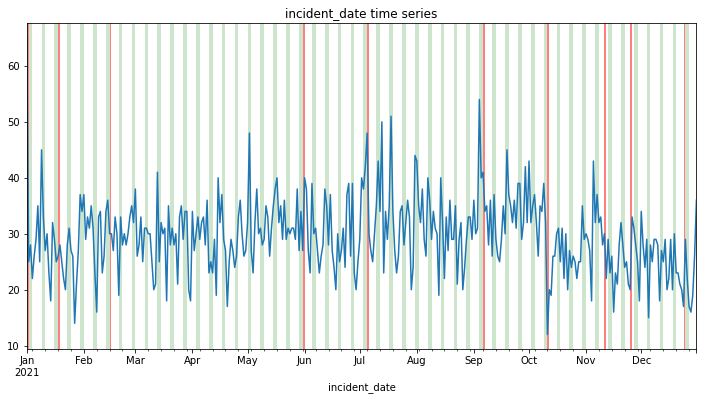

In [133]:
weekends=sorted(df_person[df_person['incident_isweekend']==True].incident_date.unique())
holidays=sorted(df_person[df_person['incident_is_holiday']==True].incident_date.unique())
df_person.groupby('incident_date')['incident_id'].nunique().plot(title='incident_date'+' time series',figsize=(12,6))
i = 0
while i < len(weekends)-1:
    plt.axvspan(weekends[i], weekends[i+1]+np.timedelta64(1,'D'), facecolor='green', edgecolor='none', alpha=.2)
    i += 2
for i in range(len(holidays)):
    plt.axvspan(holidays[i], holidays[i]+np.timedelta64(1,'D'), facecolor='red', edgecolor='none', alpha=.5)

###### It can be seen that in general there is more crime during the weekend

<AxesSubplot:xlabel='incident_day', ylabel='count'>

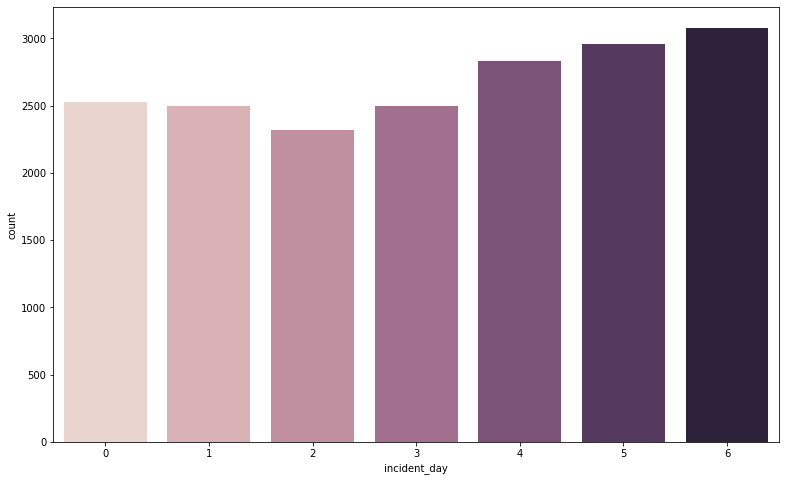

In [134]:
p1=sns.cubehelix_palette(7)
plt.figure(figsize=(13,8))
sns.countplot(x="incident_day", data=df_person,palette=p1)

###### Here we see something strange, that at 12am there is much more crimes. This might be that crimes without a recorded time are recorded at 12am by default. We'll have to take care of this anomaly.

<AxesSubplot:xlabel='incident_hour', ylabel='count'>

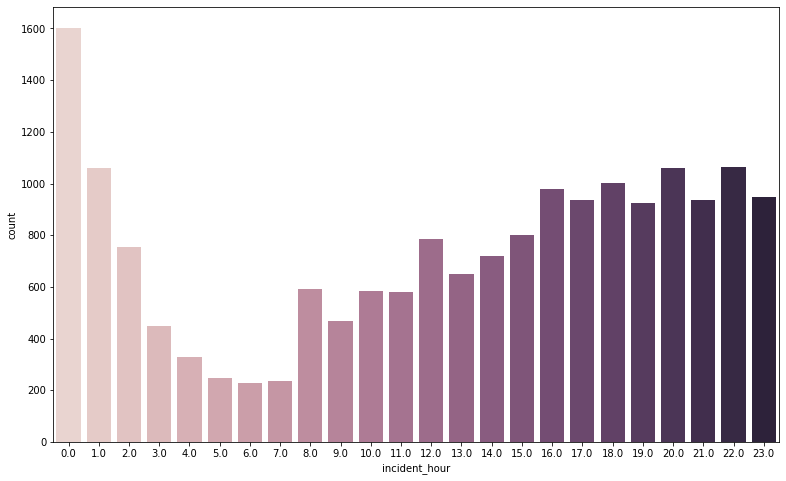

In [135]:
p2=sns.cubehelix_palette(24)
plt.figure(figsize=(13,8))
sns.countplot(x="incident_hour", data=df_person, color='grey',palette=p2)

###### It seems that theres a trend for crimes to go down along the month, although not all month have 31 days.

<AxesSubplot:xlabel='incident_dayofmonth', ylabel='count'>

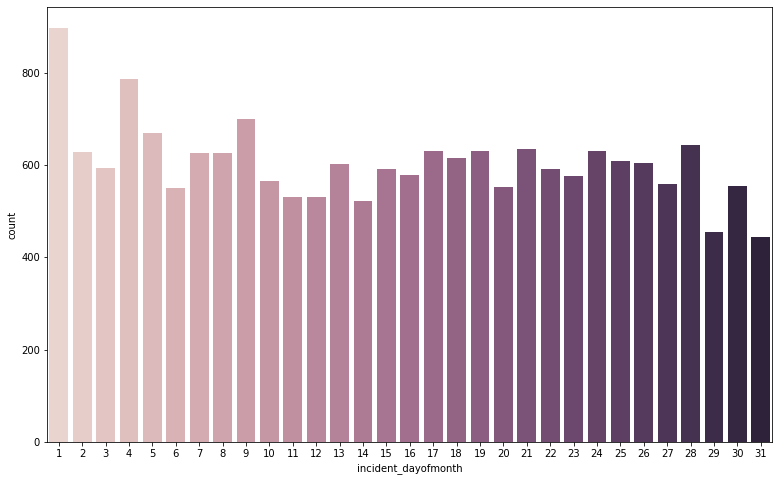

In [136]:
p3=sns.cubehelix_palette(31)
plt.figure(figsize=(13,8))
sns.countplot(x="incident_dayofmonth", data=df_person, color='grey',palette=p3)

###### Let's remove the columns with only null values


In [137]:
for df in [df_person,df_property,df_society]:
    df.dropna(thresh=2, axis=1,inplace=True)

In [138]:
df_person.relationship_name.value_counts()

Victim Was Boyfriend/Girlfriend                         2925
Victim Was Acquaintance                                 2865
Victim was Otherwise Known                              2547
Victim Was Stranger                                     1469
Victim Was Offender                                     1438
Victim Was Ex-Relationship (Ex-Boyfriend/Girlfriend)    1047
Victim Was Spouse                                        821
Victim Was Child                                         706
Relationship Unknown                                     672
Victim Was Friend                                        648
Victim Was Parent                                        605
Victim Was Sibling                                       521
Victim Was Other Family Member                           346
Victim Was Neighbor                                      288
Victim was Ex-Spouse                                     157
Victim Was Stepchild                                      85
Victim Was In-law       

###### Remove all columns where there is a class that represents more than 90% of the data

In [139]:
# Remove all columns where there is a class that represents more than 90% of the data
for df in [df_person,df_property,df_society]:
    very_imbalanced_columns=[]
    for col in tqdm(df.columns):
        if df[col].value_counts(normalize=True,dropna=False).max() >= 0.90:
            very_imbalanced_columns.append(col)
    df.drop(very_imbalanced_columns, axis=1,inplace=True)  

100%|██████████| 143/143 [00:00<00:00, 568.85it/s]


###### Remove all columns where there is more than 90% null values

In [140]:
for df in [df_person,df_property,df_society]:
    # Remove all columns where there is more than 90% null values
    to_remove=[]
    for column,null_percent in enumerate((df.isna().sum()/df.shape[0]).to_frame().values):
        if null_percent >0.90:
            to_remove.append(column)
            #print(null_percent,column)
    df.drop(columns=df.columns[to_remove], inplace=True)

###### Let's remove columns that seem irrelevant for our goal

In [141]:
for df in [df_person,df_property,df_society]:
    df.drop(columns=['num_premises_entered',
                          'age_range_low_num_victim',
                         'notes_victim'
                         ,'population_group_desc','county_name',
                         'age_range_low_num_offender',
                         'notes_offender', 'submission_date',
                         'cleared_except_date','offense_category_name',
                         'incident_status', 'did','suspected_drug_name','drug_measure_name',
                         'date_recovered', 'ori', 'legacy_ori',
                         'ucr_agency_name', 'ncic_agency_name',
                         'pub_agency_unit','prop_loss_desc',
                         'suburban_area_flag', 'parent_pop_group_desc',
                         'mip_flag', 'pe_reported_flag',
                         'nibrs_start_date', 'nibrs_leoka_start_date',
                         'nibrs_ct_start_date', 'msa_name', 'ct_flag',
                         'age_range_high_num', 'est_drug_qty',
                         'male_officer','male_civilian','criminal_act_desc',
                         'male_officer+male_civilian', 'female_officer',
                         'female_civilian', 'female_officer+female_civilian',
                         'officer_rate', 'hc_flag', 'shr_flag', 'employee_rate',
                         ], inplace=True, axis=1,errors='ignore')

###### Looking at nibrs_age csv we see that there are a minority of ages that don't correspond to a specific age. We'll remove this for simplicity

In [142]:
df_person=df_person.loc[~df_person['age_id_victim'].isin([1,2,3,103,104])]
df_person=df_person.loc[~df_person['age_id_offender'].isin([1,2,3,103,104])]

###### Let's remove columns that don't give valuable information like id and code columns

In [143]:
for df in [df_person,df_property,df_society]:
    (df.drop(columns=[i for i in list(df.filter(regex='_id'))],errors='ignore',inplace=True))
    (df.drop(columns=[i for i in list(df.filter(regex='_code')) if i!='resident_status_code'],errors='ignore',inplace=True))

###### Let's transform age to numeric

In [144]:
df_person["age_num_victim"] = pd.to_numeric(df_person["age_num_victim"])
df_person["age_num_offender"] = pd.to_numeric(df_person["age_num_offender"])

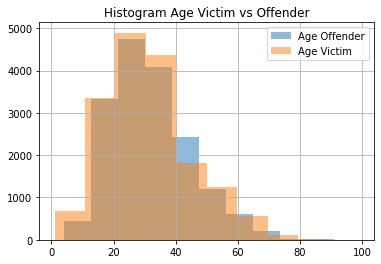

In [145]:
df_person.age_num_offender.hist(alpha=.5,label='Age Offender')
df_person.age_num_victim.hist(alpha=.5,label='Age Victim')
plt.title('Histogram Age Victim vs Offender')
plt.legend()

#### Predictions

###### We'll choose the relevant inputs and we'll predict two outputs, one numerical (age of the offender) and one categorical (race of the offender)

In [146]:
inputFeature = df_person[['victim_seq_num','age_num_victim','resident_status_code','race_desc_victim',
'ethnicity_name_victim','incident_hour','pub_agency_name','offense_name','location_name','weapon_name','population'
,'injury_name','incident_day','incident_isweekend','incident_month','incident_dayofmonth','incident_weekofyear','relationship_name']]
numerical_output = df_person[['age_num_offender']]
categorial_output = df_person[['race_desc_offender']]

##### Categorical predictions

###### We split the data into 90/10 train/test and shuffle

In [147]:
X_train, X_test, y_train, y_test = train_test_split(inputFeature, categorial_output, test_size=0.1, random_state=42,stratify=categorial_output)

In [148]:
numerical_features=['population','victim_seq_num','age_num_victim','incident_hour','incident_month','incident_day','incident_dayofmonth','incident_weekofyear']
categorical_features = ['resident_status_code','race_desc_victim',
'ethnicity_name_victim','pub_agency_name','offense_name','location_name','weapon_name'
,'injury_name','relationship_name','incident_isweekend']

###### We create a pipeline for imputing missing values, scaling the numerical features and do one hot encoding for categorical ones

In [149]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [150]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

###### We see below that all the predictors perform better than predicting the the most common value, with **Extra Trees Classifier** being the best one. Since the data is imbalanced we use Balanced Accuracy Score which is better than plain accuracy for this kind of data. We see that the classifiers do a relatively good job even with imbalanced classes. With a little bit of misclassification between white, african american and american indian or alaska native. We show the accuracy along the confusion matrix and the distribution plot for each model.

RandomForestClassifier
model Accuracy Score: 0.834
model Balanced Accuracy Score: 0.658


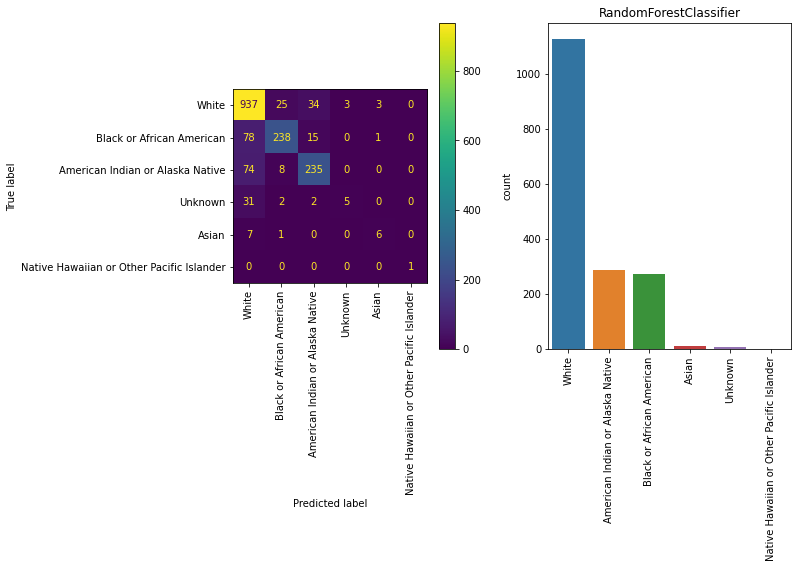

ExtraTreesClassifier
model Accuracy Score: 0.829
model Balanced Accuracy Score: 0.672


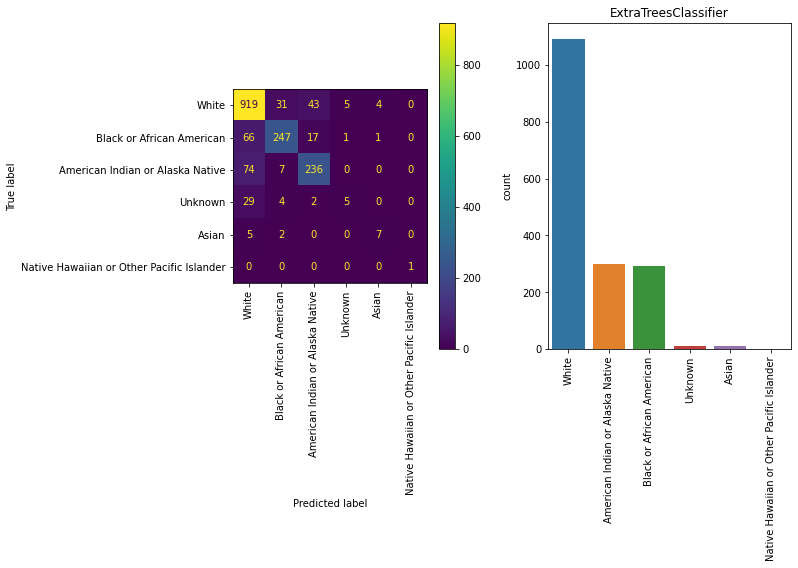

XGBClassifier
model Accuracy Score: 0.812
model Balanced Accuracy Score: 0.631


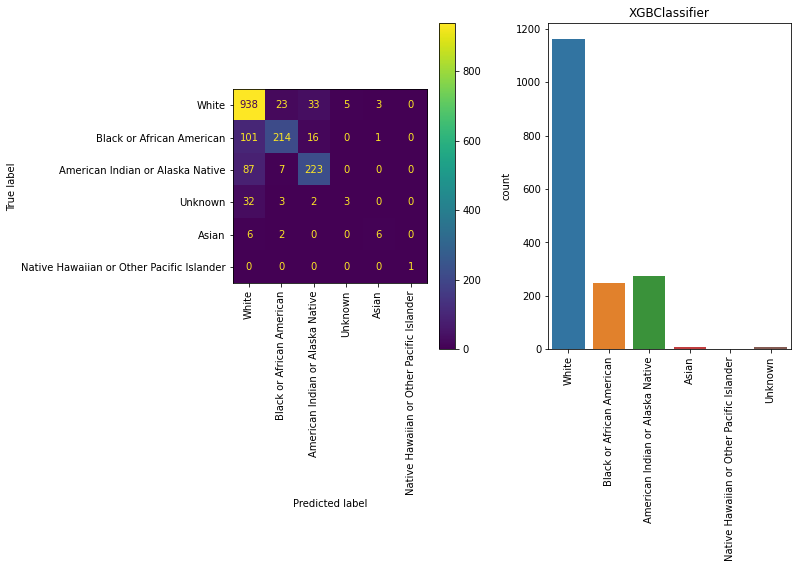

LGBMClassifier
model Accuracy Score: 0.819
model Balanced Accuracy Score: 0.654


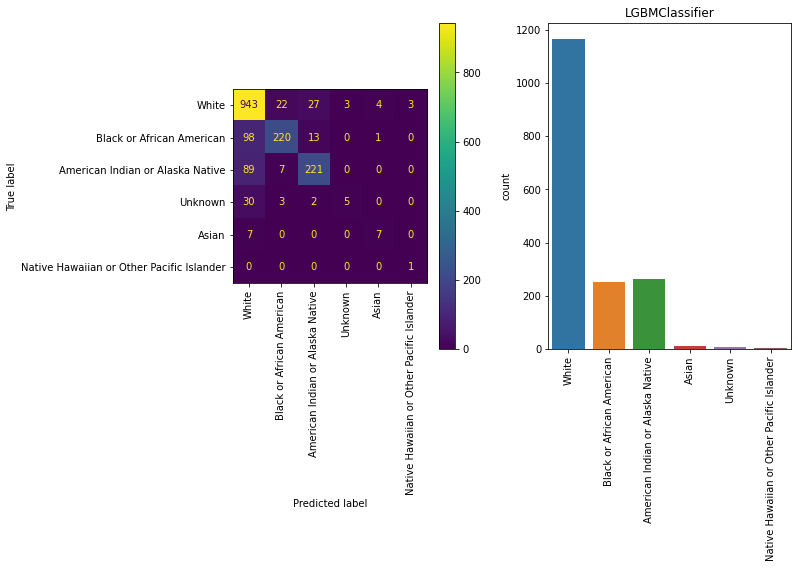

In [151]:
classifiers = [
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    XGBClassifier(random_state=42,verbosity=0,tree_method='gpu_hist', gpu_id=0),
    LGBMClassifier()
    ]

race_list=df_person.race_desc_offender.value_counts().index.tolist()

for classifier in classifiers:
    if type(classifier).__name__=='XGBClassifier':
        le = LabelEncoder()
        y_train_xgboost = le.fit_transform(y_train.values.ravel())
        y_test_xgboost = le.fit_transform(y_test.values.ravel())
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier)])
        pipe.fit(X_train, y_train_xgboost)   
        print(type(classifier).__name__)
        print("model Accuracy Score: %.3f" % pipe.score(X_test, y_test_xgboost))
        print("model Balanced Accuracy Score: %.3f" % balanced_accuracy_score(y_test_xgboost,pipe.predict(X_test)))
        confusion_matrix_race = confusion_matrix(y_test, le.inverse_transform(pipe.predict(X_test)), labels=race_list)
        # Plot normalized confusion matrix in race
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_race,
                                  display_labels=race_list)
        a4_dims = (10, 6)
        fig, ax =plt.subplots(1,2,figsize=a4_dims)
        disp.plot(xticks_rotation='vertical', ax=ax[0]) 
        sns.countplot(le.inverse_transform(pipe.predict(X_test)), ax=ax[1]).set(title=type(classifier).__name__)
        ax[1].tick_params(axis='x', rotation=90)
        fig.figure.subplots_adjust(wspace=.3)
        plt.show()
    else:
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier)])
        pipe.fit(X_train, y_train.values.ravel())   
        print(type(classifier).__name__)
        print("model Accuracy Score: %.3f" % pipe.score(X_test, y_test))
        print("model Balanced Accuracy Score: %.3f" % balanced_accuracy_score(y_test.values.ravel(),pipe.predict(X_test)))
        confusion_matrix_race = confusion_matrix(y_test, pipe.predict(X_test), labels=race_list)
        # Plot normalized confusion matrix in race
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_race,
                                  display_labels=race_list)
        a4_dims = (10, 6)
        fig, ax =plt.subplots(1,2,figsize=a4_dims)
        disp.plot(xticks_rotation='vertical', ax=ax[0]) 
        sns.countplot(pipe.predict(X_test), ax=ax[1]).set(title=type(classifier).__name__)
        ax[1].tick_params(axis='x', rotation=90)
        fig.figure.subplots_adjust(wspace=.3)
        plt.show()

###### We get the base case which is always prediciting the most common value and see it is the worst

In [152]:
race_count = df_person['race_desc_offender'].value_counts()
race_base = race_count.idxmax()

In [153]:
print("model Accuracy Score: %.3f" % accuracy_score(y_test,[race_base]*len(y_test)))
print("model Balanced Accuracy Score: %.3f" % balanced_accuracy_score(y_test,[race_base]*len(y_test)))


model Accuracy Score: 0.587
model Balanced Accuracy Score: 0.167


##### Numerical Predictions

###### We split the data into 90/10 train/test and shuffle

In [154]:
X_train, X_test, y_train, y_test = train_test_split(inputFeature, numerical_output, test_size=0.1, random_state=42)

###### We compare the R2 score, RMSE and density plots of the predicting models with the test. It seems that **Extra Trees Regressor** is a bit better than the rest, and all of them performing much better than just predicting the mean.

ExtraTreesRegressor
model R2 score: 0.586
model RMSE: 8.035
BaggingRegressor
model R2 score: 0.536
model RMSE: 8.510
RandomForestRegressor
model R2 score: 0.577
model RMSE: 8.119
XGBRegressor
model R2 score: 0.521
model RMSE: 8.641
LGBMRegressor
model R2 score: 0.525
model RMSE: 8.605


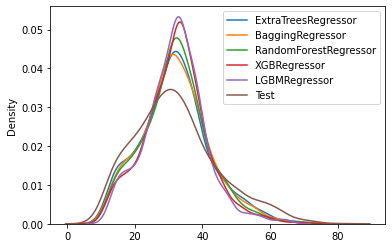

In [158]:
regressors = [
ExtraTreesRegressor()
,BaggingRegressor()
,RandomForestRegressor()
,XGBRegressor(objective="reg:squarederror", random_state=42,verbosity=0,tree_method='gpu_hist', gpu_id=0)
,LGBMRegressor()
    ]
for regressor in regressors:
    if type(regressor).__name__=='XGBRegressor':
        pipe = Pipeline(steps=[('preprocessor', preprocessor),('regressor', regressor)])
        pipe.fit(X_train, y_train.values.ravel())   
    else:
        pipe = Pipeline(steps=[('preprocessor', preprocessor),('regressor', regressor)])
        pipe.fit(X_train, y_train.values.ravel()) 
    print(type(regressor).__name__)
    print("model R2 score: %.3f" % pipe.score(X_test, y_test))
    print("model RMSE: %.3f" % mean_squared_error(y_test.values.ravel(),pipe.predict(X_test),squared=False))
    sns.kdeplot(pipe.predict(X_test),label=type(regressor).__name__)
sns.kdeplot(y_test.values.ravel(),label='Test')
plt.legend()

###### We get the base case which is always prediciting the mean and see it is the worst

In [159]:
age_base = df_person['age_num_offender'].mean()

In [170]:
print("base model R2 score: %.3f" % r2_score(y_test.values.ravel(),[age_base]*len(y_test)))
print("base model RMSE: %.3f" % mean_squared_error(y_test.values.ravel(),[age_base]*len(y_test),squared=False))

base model R2 score: -0.000
base model RMSE: 12.492
